In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from numpy.linalg import svd
from scipy.io import loadmat

mpl.rcParams['figure.figsize'] = (10.0, 5.0)
mpl.rcParams['font.size'] = 14

In [2]:
%%time
import mat73
data = mat73.loadmat(r'Downloads/SSH/EnKF_SSH_1993_2021.mat')

Wall time: 10min 32s


In [3]:
%%time
ssh = data['ssh']
lat = data['lat']
lat = lat.astype(float);
lon = data['lon']
time = data['time']


Wall time: 9 ms


In [6]:
%%time
ssh.shape


Wall time: 0 ns


(1060, 840, 10408)

In [4]:
latmax=np.max(lat)
latmin=np.min(lat)
lonmax=np.max(lon)
lonmin=np.min(lon)
nt=len(time)
nlat=int((latmax-latmin)/2+1)
nlon = int((lonmax - lonmin)/2 + 1)
ns = nlat*nlon
latlon_dim = (nlat, nlon)


In [8]:
print(latlon_dim)
print(latmax)
print(latmin)
print(lonmax)
print(lonmin)
print(nlat)
print(nlon)
print(ns)
print(nt)

(20, 22)
45.76
6.037500000000399
-55.640000000000725
-98.0
20
22
440
10408


In [5]:
ssh_new = np.empty((1060*840,int(10408/8)),dtype = float)

In [6]:
import time
tic = time.perf_counter()
for i in range(1060):
    for j in range(840):
        for k in range(int(10408/8)):
            ssh_new[i+ (j-1)* 1060,k] = ssh[i,j,k]
toc = time.perf_counter()
print(f"Finish 1/8 reshape in {(toc - tic)/60/60:0.4f} hours")

Finish 1/8 reshape in 0.2612 hours


In [ ]:
import time
tic = time.perf_counter()
ssh_new=ssh[:,:,0].reshape( (1060*840),0)
toc = time.perf_counter()
print(f"Finish one reshape in {toc - tic:0.4f} seconds")

In [8]:
ssh_new.shape

(890400, 1301)

In [ ]:
ssh_new=ssh.reshape( (ssh.shape[0]*ssh.shape[1]),ssh.shape[2])

In [ ]:
ssh_new.shape

In [9]:
land=np.isnan(ssh_new[:,0])

In [10]:
land.shape

(890400,)

In [11]:
land

array([ True,  True,  True, ...,  True,  True,  True])

In [12]:
not_land = np.logical_not(land)

In [13]:
ssh = ssh_new[not_land, :]

In [14]:
ssh.shape

(547459, 1301)

In [15]:
ssh=ssh-ssh.mean(axis=1)[:,None]

In [33]:
from sklearn.decomposition import PCA

In [34]:
pca=PCA(n_components=20)

In [35]:
pca.fit(ssh)

PCA(n_components=20)

In [36]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.09288048 0.07624466 0.05714064 0.05248179 0.03986251 0.03621913
 0.02966411 0.02785437 0.02640937 0.02508175 0.02230165 0.02031659
 0.01898207 0.01778402 0.01686053 0.01545612 0.01510538 0.01411745
 0.01384793 0.01321372]
[1018.87609016  923.13211539  799.15627141  765.8848116   667.4849065
  636.25055337  575.80415166  557.96357093  543.29811348  529.46602978
  499.26100825  476.52381584  460.60741659  445.83494041  434.10495066
  415.6323637   410.88942297  397.22571167  393.4155839   384.30118897]


In [16]:
U, sigma, V = np.linalg.svd(ssh, full_matrices=False)

In [18]:
norm_sq_S = (sigma**2).sum()
norm_sq_SSH = (ssh**2).sum()
print(f"Total variance from eigenvalues: {norm_sq_S}Total variance from SSH data: {norm_sq_SSH}")

Total variance from eigenvalues: 13219574.256430881Total variance from SSH data: 13219574.256430885


In [22]:
num_PCs = 10
var_frac1 = sigma[0]**2/norm_sq_S
var_frac2 = sigma[1]**2/norm_sq_S
var_frac3 = sigma[2]**2/norm_sq_S
var_frac4 = sigma[3]**2/norm_sq_S
var_frac5 = sigma[4]**2/norm_sq_S
var_frac6 = sigma[5]**2/norm_sq_S
var_frac7 = sigma[6]**2/norm_sq_S
var_frac8 = sigma[7]**2/norm_sq_S
var_frac9 = sigma[8]**2/norm_sq_S
var_frac10 = sigma[9]**2/norm_sq_S

print("Fraction of variance explained\nmode 1: {:.4f}\nmode 2: {:.4f}\nmode 3: {:.4f}\nmode 4: {:.4f}\nmode 5: {:.4f}\nmode 6: {:.4f}\nmode 7: {:.4f}\nmode 8: {:.4f}\nmode 9: {:.4f}\nmode 10: {:.4f}".format(var_frac1, var_frac2, var_frac3, var_frac4, var_frac5,var_frac6, var_frac7, var_frac8, var_frac9, var_frac10))

Fraction of variance explained
mode 1: 0.1937
mode 2: 0.0726
mode 3: 0.0515
mode 4: 0.0480
mode 5: 0.0404
mode 6: 0.0319
mode 7: 0.0306
mode 8: 0.0250
mode 9: 0.0235
mode 10: 0.0216


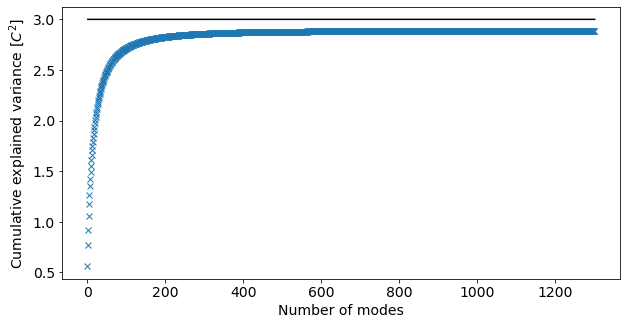

In [25]:
plt.plot((sigma**2).cumsum() / (ns*nt), 'x')  # Divide by number of entries in SST
                                              # to plot a cumulative mean square variance.    
plt.xlabel('Number of modes')
plt.ylabel('Cumulative explained variance [$C^2$]')
x = np.array(range(1,1302))
y = np.array([3]*1301)
plt.plot(x, y, color = 'black')

In [26]:
U_all = np.empty_like(ssh_new[:,0:num_PCs])
U_all[:] = np.nan
U_all[not_land, :] =  U[:,0:num_PCs]

U1 = U_all[:,0].reshape(1060, 840)
V1 = V[0,:]

In [27]:
nt=int(10408/8)
PC1 = V1*np.sqrt(nt-1)          # PC1 = V1 renormalized to have std=1
Ut1 = U1*sigma[0]/np.sqrt(nt-1) # Ut1 = SST for PC1  = +1 std.

In [32]:
V1

array([-0.01871474, -0.02960271, -0.02073247, ...,  0.00794924,
        0.02018948,  0.01582517])

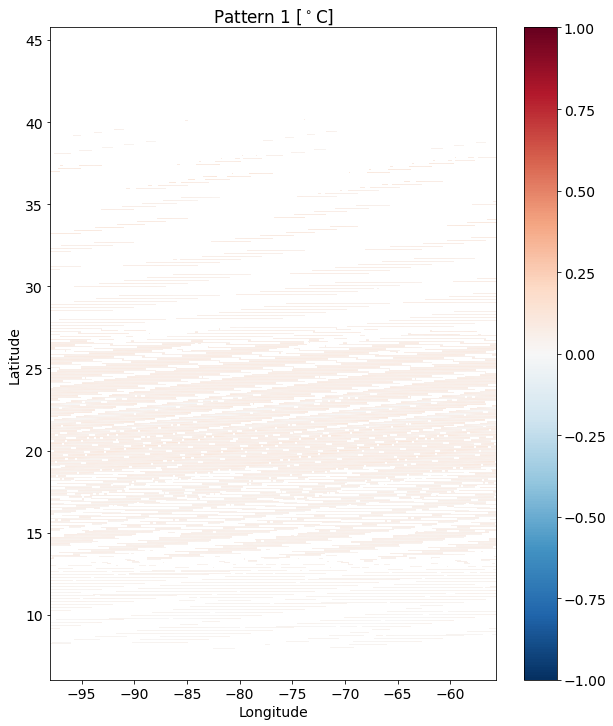

In [28]:
# Plot Spatial pattern
fig, (ax1) = plt.subplots(1,1)
fig.set_size_inches(10, 12)
image = ax1.imshow(Ut1, cmap='RdBu_r', aspect='auto',
                   interpolation='bilinear',
                   vmin=-1, vmax=1,
                   origin='lower',
                   extent=[lonmin, lonmax, latmin, latmax])
ax1.set_ylabel('Latitude')
ax1.set_xlabel('Longitude')
ax1.set_title('Pattern 1 [$^\circ$C]')
plt.colorbar(image, ax=ax1)


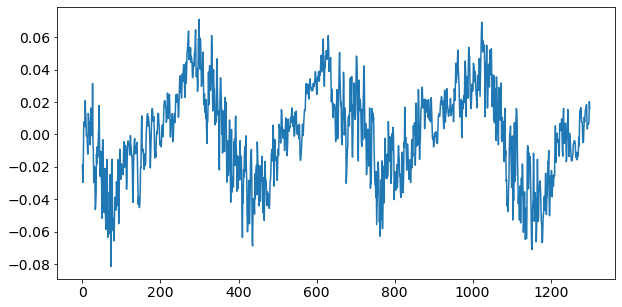

In [38]:
plt.plot(V1)
plt.show()